In [1]:
import requests
import pandas as pd
import numpy as np
import argparse
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
import os

# os.environ['KMP_DUPLICATE_LIB_OK']='True'

import torch
import torch.nn as nn

In [3]:
API_BASE_URL='https://clinicaltrials.gov/api/query'
EXAMPLE_DRUG = 'gabapentin'

## Make Data into Tables

In [4]:
def get_studies_by_expression(expression):
    r = requests.get(API_BASE_URL + '/full_studies?expr={expr}&min_rnk=1&max_rnk=99&fmt=json'
                     .format(expr=expression))
    return r.json()


def get_conditions_for_drug(drug):
    r = requests.get(API_BASE_URL + '/field_values?expr={drug}&field=ConditionAncestorTerm&fmt=json'
                     .format(drug=drug))
    
    return r.json()


def get_all_studies(expr, results=True):
    og_length = 99
    studies = []
    count = 0
    while (og_length >= 99):
        r = requests.get(API_BASE_URL + '/full_studies?expr={expr}&min_rnk={min_rank}&max_rnk={max_rank}&fmt=json'
                         .format(expr=expr, min_rank=count*99 + 1, max_rank=(count*99+1)+98))
        og_length = len(r.json()['FullStudiesResponse'].get('FullStudies', []))
        new_studies = r.json()['FullStudiesResponse'].get('FullStudies', [{'Study': []}])
        studies += list(filter(lambda x: 'ResultsSection' in x['Study'] and 'OutcomeMeasuresModule' in x['Study']['ResultsSection'], new_studies))
        count+=1
        
    return studies

studies = get_all_studies(EXAMPLE_DRUG)

In [5]:
def create_studies_table(studies, drug):
    buffer = {
        'study_id': [], 'name': [], 'drug': [], 'conditions': [], 
        'verified_date': [], 'responsible_party': [], 'type': [], 'description': [],
        'interventions': [], 'purpose': [], 'intervention_type': [], 'mesh_terms': []
              
         }
    for i, study in enumerate(studies):


        buffer['drug'].append(drug)
        try:
            buffer['study_id'].append(study['Study']['ProtocolSection']['IdentificationModule']['NCTId'])
        except KeyError as e:
            buffer['study_id'].append('NA')

        try:
            buffer['name'].append(study['Study']['ProtocolSection']['IdentificationModule']['OfficialTitle'])
        except KeyError as e:
            buffer['name'].append('NA')

        try:
            buffer['verified_date'].append(study['Study']['ProtocolSection']['StatusModule']['StatusVerifiedDate'])
        except KeryError as e:
            buffer['verified_date'].append('NA')

        try:
            buffer['responsible_party'].append(study['Study']['ProtocolSection']['SponsorCollaboratorsModule']['ResponsibleParty'])
        except KeyError as e:
            buffer['responsible_party'].append('NA')

        try: 
            buffer['conditions'].append(study['Study']['ProtocolSection']['ConditionsModule']['ConditionList']['Condition'])
        except KeyError as e:
            buffer['conditions'].append('NA')

        try:
            buffer['type'].append(study['Study']['ProtocolSection']['DesignModule']['StudyType'])
        except KeyError as e:
            buffer['type'].append('NA')
        
        buffer['purpose'].append(study['Study']['ProtocolSection']['DesignModule']['DesignInfo'].get('DesignPrimaryPurpose', 'NA'))
        buffer['intervention_type'].append(study['Study']['ProtocolSection']['DesignModule']['DesignInfo'].get('DesignInterventionModel', 'NA'))
        
        try:
            buffer['mesh_terms'].append([x.get('ConditionMeshTerm', 'NA') for x in study['Study']['DerivedSection']['ConditionBrowseModule']['ConditionMeshList']['ConditionMesh']])
        except KeyError as e:
            buffer['mesh_terms'].append([])
            
        try:
            buffer['description'].append(study['Study']['ProtocolSection']['DescriptionModule']['DetailedDescription'])
        except KeyError as e:
            buffer['description'].append('NA')
            
        try: 
            buffer['interventions'].append([x.get('InterventionMeshTerm', 'NA') for x in study['Study']['DerivedSection']['InterventionBrowseModule']['InterventionMeshList']['InterventionMesh']])
        except KeyError as e:
            buffer['interventions'].append([])
    
    return buffer


def create_groups_table(studies): # The groups in the baseline -> this might end up badly 
    groups_df = { 
        'name': [],
        'study_id': [],
        'id': [],
        'description': [],
        'participants': [],
        'maybe_arm_type': []
    }
    parts = []
    for study in studies:
        study_id = study['Study']['ProtocolSection']['IdentificationModule']['NCTId']
        groups = []
        denoms = []
        try: 
            groups = study['Study']['ResultsSection']['BaselineCharacteristicsModule']['BaselineGroupList']['BaselineGroup']
        except KeyError as e:
            groups = []
            
        # Get the type of groups from arm 
        arms = study['Study']['ProtocolSection']['ArmsInterventionsModule']['ArmGroupList'].get('ArmGroup', [])
        types = []
        for arm in arms:
            label = arm.get('ArmGroupLabel', None)
            armType = arm.get('ArmGroupType', None)
            types.append(armType)
            
        for i, group in enumerate(groups):
            groups_df['name'].append(group.get('BaselineGroupTitle', 'NA'))
            groups_df['study_id'].append(study_id)
            groups_df['id'].append(group.get('BaselineGroupId', 'NA'))
            groups_df['description'].append(group.get('BaselineGroupDescription', 'NA'))
            groups_df['maybe_arm_type'].append(types[i] if i<len(types)else 'NA')
                
        try:
            denoms = study['Study']['ResultsSection']['BaselineCharacteristicsModule']['BaselineDenomList']['BaselineDenom']
        except KeyError as e:
            denoms = []
            
        participants = list(filter(lambda x: x.get('BaselineDenomUnits', 'NA') == 'Participants', denoms))
        for participant in participants[0]['BaselineDenomCountList']['BaselineDenomCount']:
            groups_df['participants'].append(int(participant['BaselineDenomCountValue']))
            
    return groups_df, parts


def get_outcome_modules(studies):
    outcome_modules = []
    for study in studies:
        if 'OutcomeMeasuresModule' in study['Study']['ResultsSection']:
            outcome_modules.append(study['Study']['ResultsSection']['OutcomeMeasuresModule'])
            continue 
        print('No Results: ', study['Study']['ProtocolSection']['IdentificationModule']['OfficialTitle'])
        
    return outcome_modules


def create_measures_table(studies):
    outcome_modules = get_outcome_modules(studies)
    df = {
        'study_id': [],
        'measure': [],
        'type': [],
        'description': [],
        'dispersion_param': [],
        'measure_param': [],
        'units': []
    }
    
    for i, module in enumerate(outcome_modules):
        study_id = studies[i]['Study']['ProtocolSection']['IdentificationModule']['NCTId']
        for measure in module['OutcomeMeasureList']['OutcomeMeasure']:
            df['type'].append(measure.get('OutcomeMeasureType', 'NA'))
            df['measure'].append(measure.get('OutcomeMeasureTitle', 'NA'))
            df['description'].append(measure.get('OutcomeMeasureDescription', 'NA'))
            df['measure_param'].append(measure.get('OutcomeMeasureParamType', 'NA'))
            df['dispersion_param'].append(measure.get('OutcomeMeasureDispersionType', 'NA'))
            df['units'].append(measure.get('OutcomeMeasureUnitOfMeasure', 'NA'))
            df['study_id'].append(study_id)
            
    return df 


def create_outcomes_table(studies):
    outcome_modules = get_outcome_modules(studies)
    admin_df = {
        'study_id': [],
        'group_id': [],
        'measure': [],
        'title': [],
        'description': [],
    }
    
    outcome_df = {
        'study_id': [],
        'group_id': [],
        'measure': [],
        'title': [],
        'value': [],
        'dispersion': [],
        'upper': [],
        'lower': [],
        'participants': []
    }
    
    for i, module in enumerate(outcome_modules):
        study_id = studies[i]['Study']['ProtocolSection']['IdentificationModule']['NCTId']
        for measure in module['OutcomeMeasureList']['OutcomeMeasure']:
            try:
                overall_group_to_no = {}
                for denom in measure.get('OutcomeDenomList', {'OutcomeDenom': []})['OutcomeDenom']:
                    if denom.get('OutcomeDenomUnits', 'NA') == 'Participants':
                        for count in denom.get('OutcomeDenomCountList', {'OutcomeDenomCount': []})['OutcomeDenomCount']:
                            overall_group_to_no[count['OutcomeDenomCountGroupId']] = count['OutcomeDenomCountValue']
                                
                for admin in measure.get('OutcomeGroupList', {'OutcomeGroup': []})['OutcomeGroup']:
                    admin_df['study_id'].append(study_id)
                    admin_df['group_id'].append(admin.get('OutcomeGroupId', 'NA'))
                    admin_df['measure'].append(measure.get('OutcomeMeasureTitle', 'NA'))
                    admin_df['title'].append(admin.get('OutcomeGroupTitle', 'NA'))
                    admin_df['description'].append(admin.get('OutcomeGroupDescription', 'NA'))
                    
                # Sometimes the participants are just listed one time before all the others - not just in the class
                for group in measure.get('OutcomeClassList', {'OutcomeClass': []})['OutcomeClass']:
    
                    group_to_no = {}
                    for denom in group.get('OutcomeClassDenomList', {'OutcomeClassDenom': []})['OutcomeClassDenom']:
                        for count in denom.get('OutcomeClassDenomCountList', {'OutcomeClassDenomCount': []})['OutcomeClassDenomCount']:
                            group_to_no[count['OutcomeClassDenomCountGroupId']] = count['OutcomeClassDenomCountValue']

                    for cat in group.get('OutcomeCategoryList', {'OutcomeCategory': []})['OutcomeCategory']:
                        for outcome in cat['OutcomeMeasurementList']['OutcomeMeasurement']:
                            outcome_df['study_id'].append(study_id)
                            outcome_df['group_id'].append(outcome.get('OutcomeMeasurementGroupId', 'NA'))
                            outcome_df['measure'].append(measure.get('OutcomeMeasureTitle', 'NA'))
                            outcome_df['value'].append(outcome.get('OutcomeMeasurementValue', 'NA'))
                            outcome_df['dispersion'].append(outcome.get('OutcomeMeasurementSpread', 'NA'))
                            outcome_df['upper'].append(outcome.get('OutcomeMeasurementUpperLimit', 'NA'))
                            outcome_df['lower'].append(outcome.get('OutcomeMeasurementLowerLimit', 'NA'))
                            outcome_df['participants'].append(group_to_no.get(outcome.get('OutcomeMeasurementGroupId', 'NA'), None) or overall_group_to_no.get(outcome.get('OutcomeMeasurementGroupId', 'NA'), 'NA'))
                            outcome_df['title'].append(group.get('OutcomeClassTitle', 'NA'))
                        
                    
            except KeyError as e:
                print(e)
                continue
                
    return (admin_df, outcome_df)


def create_analytics_table(studies):
    outcome_modules = get_outcome_modules(studies)
    df = {
        'study_id': [],
        'measure': [],
        'groups': [],
        'description': [], # may or may not be the outcome title
        'method': [],
        'param_type': [],
        'fromStudy': [],
        'pval': [],
        'group_titles': []
    }
    
    for i, module in enumerate(outcome_modules):
        study_id = studies[i]['Study']['ProtocolSection']['IdentificationModule']['NCTId']
        for measure in module['OutcomeMeasureList']['OutcomeMeasure']:
            group_to_title = {}
            for group in measure.get('OutcomeGroupList', {'OutcomeGroup': []})['OutcomeGroup']:
                if group['OutcomeGroupId'] not in group_to_title:
                    group_to_title[group['OutcomeGroupId']] = 'NA'
                group_to_title[group['OutcomeGroupId']] = group.get('OutcomeGroupTitle', 'NA')
                    
            measure_title = measure.get('OutcomeMeasureTitle', 'NA')
            for stat in measure.get('OutcomeAnalysisList', {'OutcomeAnalysis': []})['OutcomeAnalysis']:
                df['study_id'].append(study_id)
                df['measure'].append(measure_title)
                df['groups'].append(stat.get('OutcomeAnalysisGroupIdList', {'OutcomeAnalysisGroupId': []})['OutcomeAnalysisGroupId'])
                df['description'].append(stat.get('OutcomeAnalysisGroupDescription', 'NA'))
                df['method'].append(stat.get('OutcomeAnalysisStatisticalMethod', 'NA'))
                df['param_type'].append(stat.get('OutcomeAnalysisParamType', 'NA'))
                df['fromStudy'].append(True)
                df['pval'].append(stat.get('OutcomeAnalysisPValue', 'NA'))
                df['group_titles'].append(dict([(g, group_to_title.get(g, 'NA')) for g in stat.get('OutcomeAnalysisGroupIdList', {'OutcomeAnalysisGroupId': []})['OutcomeAnalysisGroupId']]))
    return df


def create_effects_table(studies, drug):
    df = {
        'drug': [],
        'study_id': [],
        'group_id': [],
        'effect_name': [],
        'type': [], #Serious or other
        'organ_system': [],
        'assesment': [],
        'no_effected': [],
        'collection_threshold': []
    }
    for i, study in enumerate(studies):
        study_id = study['Study']['ProtocolSection']['IdentificationModule']['NCTId']
        adverse_module = study['Study']['ResultsSection'].get('AdverseEventsModule', {}) #Small risk here
        for event in adverse_module.get('OtherEventList', {'OtherEvent': []})['OtherEvent']:
            for stat in event.get('OtherEventStatsList', {'OtherEventStats': []})['OtherEventStats']:
                df['drug'].append(drug)
                df['study_id'].append(study_id)
                df['group_id'].append(stat.get('OtherEventStatsGroupId', 'NA'))
                df['effect_name'].append(event.get('OtherEventTerm', 'NA'))
                df['type'].append('other')
                df['organ_system'].append(event.get('OtherEventOrganSystem', 'NA'))
                df['assesment'].append(event.get('OtherEventAssessmentType', 'NA'))
                df['no_effected'].append(float(stat.get('OtherEventStatsNumAffected', 0)) or float(stat.get('OtherEventStatsNumEvents', 0)))
                df['collection_threshold'].append(float(adverse_module.get('EventsFrequencyThreshold', -1)))
    return df

def create_analytics_table(studies):
    outcome_modules = get_outcome_modules(studies)
    df = {
        'study_id': [],
        'measure': [],
        'groups': [],
        'description': [], # may or may not be the outcome title
        'method': [],
        'param_type': [],
        'fromStudy': [],
        'pval': [],
        'group_titles': []
    }
    
    for i, module in enumerate(outcome_modules):
        study_id = studies[i]['Study']['ProtocolSection']['IdentificationModule']['NCTId']
        for measure in module['OutcomeMeasureList']['OutcomeMeasure']:
            group_to_title = {}
            for group in measure.get('OutcomeGroupList', {'OutcomeGroup': []})['OutcomeGroup']:
                if group['OutcomeGroupId'] not in group_to_title:
                    group_to_title[group['OutcomeGroupId']] = 'NA'
                group_to_title[group['OutcomeGroupId']] = group.get('OutcomeGroupTitle', 'NA')
                    
            measure_title = measure.get('OutcomeMeasureTitle', 'NA')
            for stat in measure.get('OutcomeAnalysisList', {'OutcomeAnalysis': []})['OutcomeAnalysis']:
                df['study_id'].append(study_id)
                df['measure'].append(measure_title)
                df['groups'].append(stat.get('OutcomeAnalysisGroupIdList', {'OutcomeAnalysisGroupId': []})['OutcomeAnalysisGroupId'])
                df['description'].append(stat.get('OutcomeAnalysisGroupDescription', 'NA'))
                df['method'].append(stat.get('OutcomeAnalysisStatisticalMethod', 'NA'))
                df['param_type'].append(stat.get('OutcomeAnalysisParamType', 'NA'))
                df['fromStudy'].append(True)
                df['pval'].append(stat.get('OutcomeAnalysisPValue', 'NA'))
                df['group_titles'].append(dict([(g, group_to_title.get(g, 'NA')) for g in stat.get('OutcomeAnalysisGroupIdList', {'OutcomeAnalysisGroupId': []})['OutcomeAnalysisGroupId']]))
    return df


In [6]:
def create_all_tables(drug):
    studies_table = pd.DataFrame.from_dict(create_studies_table(studies, drug))
    groups_table = pd.DataFrame.from_dict(create_groups_table(studies)[0])
    measures_table = pd.DataFrame.from_dict(create_measures_table(studies))
    admin_df, outcome_df = create_outcomes_table(studies)
    admins_table = pd.DataFrame.from_dict(admin_df)
    outcomes_table = pd.DataFrame.from_dict(outcome_df)
    analytics = pd.DataFrame.from_dict(create_analytics_table(studies))

    return studies_table, groups_table, measures_table, admin_df, outcome_df, admins_table, outcomes_table, analytics

studies_table, groups_table, measures_table, admin_table, outcome_table, admins_table, outcomes_table, analytics_table = create_all_tables(EXAMPLE_DRUG)
admin_table = pd.DataFrame.from_dict(admin_table)

## Labeling
- Let's get a small table to label the important parts of the data

In [7]:
# As we are now focusing on a different and more comparative approach to the data
# We want to know the treatments (or lack of) used in every treatment group
# We can do some clever stuff with the dataset to tag some of the possible treatments:
# we enumerate the treatents used in the dataset and construct a large hitlist
# we then do a glance and add in some more labels
studies_table

,study_id,name,drug,conditions,verified_date,responsible_party,type,description,interventions,purpose,intervention_type,mesh_terms
0,NCT01675960,"A Phase II, Randomized, Placebo-controlled, Do...",gabapentin,"[Neurologically Impaired, Irritable Mood, Sign...",July 2019,{'ResponsiblePartyType': 'Sponsor'},Interventional,"This is a randomized, placebo-controlled, cros...",[Gabapentin],Treatment,Crossover Assignment,"[Sleep Initiation and Maintenance Disorders, C..."
1,NCT02359110,Administration of Pre-Operative Gabapentin to ...,gabapentin,[Postoperative Pain],March 2018,{'ResponsiblePartyType': 'Principal Investigat...,Interventional,The purpose of this study is to prospectively ...,[Gabapentin],Treatment,Parallel Assignment,"[Pain, Postoperative]"
2,NCT01977937,Pain Control in Pediatric Posterior Spine Fusi...,gabapentin,"[Pain, Postoperative]",May 2019,{'ResponsiblePartyType': 'Principal Investigat...,Interventional,Patients aged 10-19 years with idiopathic scol...,[Gabapentin],Treatment,Parallel Assignment,"[Pain, Postoperative]"
3,NCT03334903,Gabapentin Regimens and Their Effects on Opioi...,gabapentin,"[Knee Osteoarthritis, Knee Pain Chronic, Opioi...",February 2021,{'ResponsiblePartyType': 'Principal Investigat...,Interventional,The purpose of this study is to determine the ...,[Gabapentin],Treatment,Parallel Assignment,"[Osteoarthritis, Knee, Opioid-Related Disorders]"
4,NCT02052414,"Open Labeled, Non-randomized, Study of Efficac...",gabapentin,[Fibromyalgia],September 2016,{'ResponsiblePartyType': 'Sponsor'},Interventional,Subject must carry a diagnosis of fibromyalgia...,[Gabapentin],Treatment,Single Group Assignment,"[Fibromyalgia, Myofascial Pain Syndromes]"
...,...,...,...,...,...,...,...,...,...,...,...,...
114,NCT03330119,"Determining the Effect of an ""Alternate Recove...",gabapentin,"[Pregnancy Related, Narcotic Use]",March 2021,{'ResponsiblePartyType': 'Principal Investigat...,Interventional,"""Enhanced recovery"" is a multi-modal, evidence...",[],Supportive Care,Parallel Assignment,[]
115,NCT00386243,Evaluation of Stepped Care for Chronic Pain in...,gabapentin,"[Low Back Pain, Pain, Pain, Intractable]",May 2019,{'ResponsiblePartyType': 'Sponsor'},Interventional,Through the Evaluation of Stepped Care for Chr...,"[Analgesics, Opioid, Analgesics]",Treatment,Parallel Assignment,"[Low Back Pain, Chronic Pain, Pain, Intractable]"
116,NCT03975790,Comparative Analysis of Outcomes Among Patient...,gabapentin,[Rheumatoid Arthritis],September 2019,{'ResponsiblePartyType': 'Sponsor'},Observational,NA,[],NA,NA,"[Arthritis, Arthritis, Rheumatoid]"
117,NCT01524796,NEP-TUNE: Neuropathic Pain - Treatment With Pr...,gabapentin,[Peripheral Neuropathic Pain],March 2015,{'ResponsiblePartyType': 'Sponsor'},Observational,General practitioners and specialists particip...,[Pregabalin],NA,NA,[Neuralgia]


In [8]:
# We need to start by getting all the treatmnets of a bunch of studies - we can query
# Read the some of the studies from the file 
from os import listdir
from os.path import isfile, join, isdir
import json
intervention_freq = {}
study_directories = [f for f in listdir('AllAPIJSON/') if isdir(join('AllAPIJSON/', f))]
MAX_STUDY_DIRS=10

for i in range(MAX_STUDY_DIRS):
    directory = study_directories[i]
    studyFileNames = [f for f in listdir('AllAPIJSON/'+directory+'/')]
    studies = []
    for file in studyFileNames:
        with open('AllAPIJSON/'+directory+'/'+file) as f:
            data = json.load(f)
            studies.append(data['FullStudy']) # Indexed like we did the tables above


    for study in studies: 
        try:
            for int_group in study['Study']['DerivedSection']['InterventionBrowseModule']['InterventionMeshList']['InterventionMesh']:
                if int_group['InterventionMeshTerm'] not in intervention_freq:
                    intervention_freq[int_group['InterventionMeshTerm']] = 0
                intervention_freq[int_group['InterventionMeshTerm']] += 1

        except KeyError as e:
            continue

## Word Embeddings
- Creating our own embeddings using pytorch and the vocabulary

In [9]:
# Get all words:
# We need to split up th different sources, maybe even split the sentences within the sources.
corpus = []
# Studies table first
for description in studies_table['description']:
    corpus.append(description)
for name in studies_table['name']:
    corpus.append(name)

# Groups table
for description in groups_table['description']:
    corpus.append(description)

# Measures table
for name in measures_table['measure']:
    corpus.append(name)
for description in groups_table['description']:
    corpus.append(description)

for title in admin_table['title']:
    corpus.append(title)
for description in admin_table['description']:
    corpus.append(description)
    
# Remove all dupes and make a word_to_idx
from nltk import word_tokenize, sent_tokenize

for i, item in enumerate(corpus):
    corpus[i] = sent_tokenize(item)
    
#Flatten it
corpus = [item for sublist in corpus for item in sublist]

for i, sentence in enumerate(corpus):
    corpus[i] = word_tokenize(sentence)

In [10]:
vocabulary = ['PAD']
for sentence in corpus:
    for token in sentence:
        if token.lower() not in vocabulary:
            vocabulary.append(token.lower())

word2idx = {w: idx for (idx, w) in enumerate(vocabulary)}
idx2word = {idx: w for (idx, w) in enumerate(vocabulary)}

vocabulary_size = len(vocabulary)

In [11]:
vocabulary_size

4662

In [12]:
window_size = 2
idx_pairs = []
for sentence in corpus:
    indices = [word2idx[word.lower()] for word in sentence]
    for center_word_pos in range(len(indices)):
        for w in range(-window_size, window_size + 1):
            context_word_pos = center_word_pos + w
            
            # make soure not jump out sentence
            if context_word_pos < 0 or context_word_pos >= len(indices) or center_word_pos == context_word_pos:
                continue
            context_word_idx = indices[context_word_pos]
            idx_pairs.append((indices[center_word_pos], context_word_idx))

idx_pairs = np.array(idx_pairs)

In [28]:
from torch.autograd import Variable
import torch.functional as F
import torch.nn.functional as F

def get_input_layer(word_idx):
    x = torch.zeros(vocabulary_size).float()
    x[word_idx] = 1.0
    return x


embedding_dims = 6
W1 = Variable(torch.randn(embedding_dims, vocabulary_size).float(), requires_grad=True)
W2 = Variable(torch.randn(vocabulary_size, embedding_dims).float(), requires_grad=True)
num_epochs = 100
learning_rate = 0.001

for epo in range(num_epochs):
    loss_val = 0
    for data, target in idx_pairs:
        x = Variable(get_input_layer(data)).float()
        y_true = Variable(torch.from_numpy(np.array([target])).long())

        z1 = torch.matmul(W1, x)
        z2 = torch.matmul(W2, z1)
    
        log_softmax = F.log_softmax(z2, dim=0)

        loss = F.nll_loss(log_softmax.view(1,-1), y_true)
        loss_val += loss.item()
        loss.backward()
        W1.data -= learning_rate * W1.grad.data
        W2.data -= learning_rate * W2.grad.data

        W1.grad.data.zero_()
        W2.grad.data.zero_()
    
    print(f'Loss at epo {epo}: {loss_val/len(idx_pairs)}')

KeyboardInterrupt: 

In [202]:
# torch.save(W1, 'w1.pt')
# torch.save(W2, 'w2.pt')

In [12]:
# Load weights
word2vec1 = torch.load('w1.pt') # [embed_dim, vocab_size]
word2vec2 = torch.load('w2.pt') # [vocab_size, embed_dim]

In [27]:
def get_word_embed(word):
    word_idx = word2idx[word]
    x = torch.zeros(vocabulary_size).float()
    x[word_idx] = 1.0
    
    return torch.matmul(word2vec1, x)


### Testing
- Let's do a projection and see how our word2vec clustered

In [14]:
from sklearn.manifold import TSNE

weights_arr = word2vec2.detach().numpy()
# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 200)

# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(weights_arr[:400])

/Users/porterhunley/anaconda3/envs/nlp/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


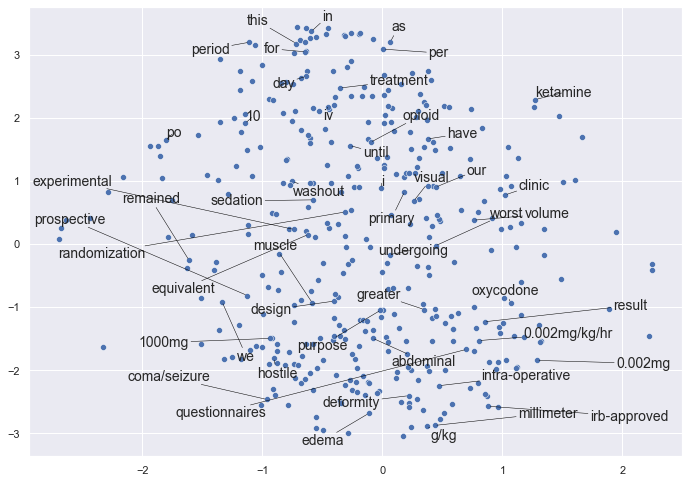

In [15]:
sns.set()
# Initialize figure
fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 1)

from adjustText import adjust_text
texts = []
words_to_plot = list(np.arange(0, 400, 8))

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], idx2word[word], fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.7, force_text = 1, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

## Group Types
- Labelign the types of each group such that we can aggregate them later to run some analysis. Group types can consist of controls, single drug, multi-drug

### NER for Treatments
- Logic behind this is that we can get the treatment used in each group and combine that with the measure used to get a good comparasion rate that we can aggregate later

In [12]:
# first we filter out studies that arent liek this
labled_admins = pd.read_csv('ner_table.csv')

In [13]:
# add a tokenized representation of the admin group with the title and description
# average the vectors together to form the document vector 
# Need to add in the description to the mix
# remove the stop words from both as well

from nltk.tokenize import word_tokenize, sent_tokenize

def tokenize_sentence(sent):
    sents = sent_tokenize(sent)
    hd_tokens = [word_tokenize(x.lower()) for x in sents]
    tokens = [item for sublist in hd_tokens for item in sublist]
    
    return tokens

token_titles = labled_admins['title'].apply(lambda x: tokenize_sentence(x))
token_desc = labled_admins['description'].apply(lambda x: tokenize_sentence(x))

labled_admins['tokens'] = token_titles + token_desc

In [14]:
# def str_contains_int(string):
#     treats = []
#     for treatment in intervention_freq.keys():
#         if treatment.lower() in string:
#             treats.append(treatment)
#     return treats


# interventional_admins['treatments'] = interventional_admins['tokens'].apply(lambda x: str_contains_int(x))

In [15]:
# output these to a table for some quick adjsuting before we hit it with BERT
# interventional_admins[['title', 'treatments','description']].to_csv('ner.csv')

In [16]:
# let's merge our labels
# some_merge = interventional_admins.merge(labeled_ner[['title', 'description', 'treatments', 'NER']], 'inner', ['title', 'description'])
# some_merge.to_csv('ner_table')

In [17]:
# We can use a combination of NER, the title, placebo/similar words used to get the groups
# Essentailly the model needs to choose one or more of the NERs parsed from the model to answer the 
# "What was administerd?" question

# Need to tag the data similar to how we did in class
# Add padding to the tokens here
# max_len = len(max(labled_admins['tokens'].tolist(), key=len))
# padded = [tok+['<pad>']*(max_len-len(tok)) for tok in labled_admins['tokens']]


In [18]:
import re

idxs = [[word2idx[x] for x in y] for y in labled_admins['tokens'].tolist()]
miscs = labled_admins['NER']
l_labels = []
for item in miscs:
    if isinstance(item, str):
        chars = re.sub('[^®0-9a-zA-Z,/-]+', '', item)
        words = chars.split(',')
        l_labels.append(words)
        continue
        
    l_labels.append(item)

label_idxs = [[word2idx[x.lower()] for x in y if x] for y in l_labels]

label2tag = {}
for label in label_idxs:
    for idx in label:
        label2tag[idx] = 1
        

tags = []
for i,label in enumerate(label_idxs):
    if not label:
        tags.append([0 for x in idxs[i]])
        continue
        
    tags.append([label2tag.get(x, 0) for x in idxs[i]])
        

In [19]:
# Lol we need to tokenize everything differently
# Also add in padding masks due to attentions and batches
# Do something about the paddign here
from transformers import BertTokenizer

bert_tokenizer = BertTokenizer("bert-base-uncased-vocab.txt", lowercase=True)
def tokenize_and_preserve_tags(token_sent, tags):
    new_sent = []
    new_labels = []
    
    for word, tag in zip(token_sent, tags):
        tokenized_words = bert_tokenizer.tokenize(word)
        
        new_sent.extend(tokenized_words)
        new_labels.extend([tag]*len(tokenized_words))
    return new_sent, new_labels



tokens_and_tags=[tokenize_and_preserve_tags(tokens, tag) for tokens, tag in zip(labled_admins['tokens'].tolist(), tags)]

In [20]:
# Pad out the sequence

MAX_LEN = 150

# Post padding with PAD
padded_text = []
padded_tags = [] # 0 or 1 
for text, tag in tokens_and_tags:
    if (MAX_LEN < len(text)):
        padded_text.append(text[:MAX_LEN])
        padded_tags.append(tag[:MAX_LEN])
        continue
    
    padded_text.append(text+['PAD']*(MAX_LEN-len(text)))
    padded_tags.append(tag+[2]*(MAX_LEN-len(text)))
    
# Turn the text into IDs - PAD is equal to 100 here
input_ids = [bert_tokenizer.convert_tokens_to_ids(x) for x in padded_text]

# Remove the padding from attention
attention_masks = [[float(i != 100) for i in ii] for ii in input_ids]

In [21]:
from sklearn.model_selection import train_test_split

# Split the dataset

tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, padded_tags, random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=2018, test_size=0.1)

# Turn into tensors
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [22]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
BATCH_SIZE = 32 # As suggested by the BERT paper
# Randomly sample the data

train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE)

#### Setting up BERT

In [24]:
from transformers import BertForTokenClassification, AdamW

model = BertForTokenClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2,
    output_attentions = False,
    output_hidden_states = False
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

In [25]:
# We can also use a linear classifier on top of BERT if performance becomes an issue

FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [26]:
# A schedular that linearaly reduces the learning rate through each epoch

from transformers import get_linear_schedule_with_warmup

epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


In [27]:
from seqeval.metrics import accuracy_score
from sklearn.metrics import f1_score
from tqdm import tqdm, trange

## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().numpy()
        label_ids = b_labels.numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [p_i for p, l in zip(predictions, true_labels) for p_i, l_i in zip(p, l) if l_i != 2]
    valid_tags = [l_i for l in true_labels for l_i in l if l_i != 2] # Need a different no for padding
    
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Average train loss: 0.31393814980983736


Epoch:  33%|███▎      | 1/3 [05:25<10:50, 325.04s/it]

Validation loss: 0.15667975693941116
Validation Accuracy: 0.953227931488801
Validation F1-Score: 0.843956043956044

Average train loss: 0.12631331160664558


Epoch:  67%|██████▋   | 2/3 [10:44<05:21, 321.47s/it]

Validation loss: 0.06649020873010159
Validation Accuracy: 0.9762845849802372
Validation F1-Score: 0.9227467811158798

Average train loss: 0.08758251406252385


Epoch: 100%|██████████| 3/3 [16:24<00:00, 328.16s/it]

Validation loss: 0.05216990504413843
Validation Accuracy: 0.9762845849802372
Validation F1-Score: 0.9246861924686193



In [ ]:
# Save the model
torch.save(model.state_dict())

#### Evaluation

In [25]:
model.load_state_dict(torch.load('BERT_NER.pt'))

<All keys matched successfully>

In [36]:
def evaluate_string(string, model):
    # First tokenize the string
    model.eval()
    tokens = bert_tokenizer.tokenize(string)
    ids = bert_tokenizer.convert_tokens_to_ids(tokens)
    model_input = torch.tensor(ids).unsqueeze(0)
    output = model(model_input) # Doesn't need a mask because no padding here
    idxs = list(torch.max(output[0], dim=2))[1]
    return idxs.tolist()[0]
    
    

In [39]:
# Let's grab a random sentence from the set and see what it does
sentence = "Group 5a enrolled participants between 91 days of age and 180 days of age. They received ATV (powder), ritonavir, and two NRTIs.\n\nATV Dose Tested: 310 mg/m^2; Final Dose: 310 mg/m^2"

sentence_tags = evaluate_string(sentence, model)
sentence_tokens = bert_tokenizer.tokenize(sentence)
sentence_and_tags = zip(sentence_tokens, sentence_tags)
for token, tag in sentence_and_tags:
    print(token, tag)


group 0
5 0
##a 0
enrolled 0
participants 0
between 0
91 0
days 0
of 0
age 0
and 0
180 0
days 0
of 0
age 0
. 0
they 0
received 0
atv 0
( 0
powder 0
) 0
, 0
ri 1
##ton 1
##avi 1
##r 1
, 0
and 0
two 0
nr 0
##tis 0
. 0
atv 0
dose 0
tested 0
: 0
310 0
mg 0
/ 0
m 0
^ 0
2 0
; 0
final 0
dose 0
: 0
310 0
mg 0
/ 0
m 0
^ 0
2 0


In [36]:
# Let's see the similar words to placebo
from numpy import dot
from numpy.linalg import norm

def similarity_to_placebo(word):
    word_emb = get_word_embed(word).detach().numpy()
    placebo_emb = get_word_embed('placebo').detach().numpy()
    
    cos_sim = dot(placebo_emb, word_emb)/(norm(placebo_emb)*norm(word_emb))
    return cos_sim

In [50]:
simple_emb = get_word_embed('morphine').detach().numpy()
syrup_emb = get_word_embed('pill').detach().numpy()
avg = (simple_emb+syrup_emb) / 2

placebo_emb = get_word_embed('placebo').detach().numpy()
dot(placebo_emb, avg)/(norm(placebo_emb)*norm(avg))

0.8966911

### Name Clustering
- Let's see how far name clustering can get to construct these groups

In [16]:
def embed_str_col(col):
    return col.apply(lambda x: [get_word_embed(y) for y in x])
    

In [22]:



tokenized_group = token_titles + token_desc

In [23]:
tokenized_group

0       [gabapentin, neurotin, gabapentin, :, the, act...
1       [placebo, glycerin, based, clear, solution, th...
4       [gabapentin, patients, will, receive, gabapent...
5       [placebo, patients, will, receive, methylcellu...
10      [gabapentin, gabapentin, 15, milligrams, per, ...
                              ...                        
2230    [all, participants, all, 42, evaluable, partic...
2233    [all, participants, thirty-two, participants, ...
2234    [amputation, group, participants, had, metasta...
2235    [limb, sparing, group, participants, had, loca...
2236    [entire, study, group, participants, enrolled,...
Length: 332, dtype: object

In [24]:
from nltk.tokenize import word_tokenize, sent_tokenize
# Get the embeddings and use the SIF method

def get_weight_map(docs):
    # count the document frequency of the words
    freq = {}
    for doc in docs:
        unique_tokens = list(set(doc))
        for token in unique_tokens:
            if token not in freq:
                freq[token] = 0
            freq[token] += 1
    
    word2weight = {}
    for item, no in freq.items():
        word2weight[item] = -1 * np.log(no/len(docs))
        
    return word2weight
    
word2weight = get_weight_map(tokenized_group)

In [25]:
idx2weight = {}
for word, weight in word2weight.items():
    try:
        idx = word2idx[word.lower()]
    except Exception as e:
        print(word)
    idx2weight[idx] = weight

In [26]:
word2idx['%$%'] = -1
idx2weight[-1] = 0
word2weight['%$%'] = 0
longest_length = len(max(tokenized_group, key=len))
padded = [x + ['%$%']*(longest_length-len(x)) for x in tokenized_group]
paddedIdx = np.array([[word2idx[x.lower()] for x in y] for y in padded])
paddedWeights = np.array([[word2weight[x.lower()] for x in y] for y in padded])

In [27]:
# Let's try unweighted
from sklearn.decomposition import TruncatedSVD


def get_weighted_average(We, x, w):
    """
    Compute the weighted average vectors
    :param We: We[i,:] is the vector for word i
    :param x: x[i, :] are the indices of the words in sentence i
    :param w: w[i, :] are the weights for the words in sentence i
    :return: emb[i, :] are the weighted average vector for sentence i
    """
    n_samples = x.shape[0]
    emb = np.zeros((n_samples, We.shape[1]))
    for i in range(n_samples):
        emb[i,:] = w[i,:].dot(We[x[i,:],:]) / np.count_nonzero(w[i,:])
    return emb

def compute_pc(X,npc=1):
    """
    Compute the principal components. DO NOT MAKE THE DATA ZERO MEAN!
    :param X: X[i,:] is a data point
    :param npc: number of principal components to remove
    :return: component_[i,:] is the i-th pc
    """
    svd = TruncatedSVD(n_components=npc, n_iter=7, random_state=0)
    svd.fit(X)
    return svd.components_

def remove_pc(X, npc=1):
    """
    Remove the projection on the principal components
    :param X: X[i,:] is a data point
    :param npc: number of principal components to remove
    :return: XX[i, :] is the data point after removing its projection
    """
    pc = compute_pc(X, npc)
    if npc==1:
        XX = X - X.dot(pc.transpose()) * pc
    else:
        XX = X - X.dot(pc.transpose()).dot(pc)
    return XX


def SIF_embedding(We, x, w, rmpc):
    """
    Compute the scores between pairs of sentences using weighted average + removing the projection on the first principal component
    :param We: We[i,:] is the vector for word i
    :param x: x[i, :] are the indices of the words in the i-th sentence
    :param w: w[i, :] are the weights for the words in the i-th sentence
    :param params.rmpc: if >0, remove the projections of the sentence embeddings to their first principal component
    :return: emb, emb[i, :] is the embedding for sentence i
    """
    emb = get_weighted_average(We, x, w)
    if  rmpc > 0:
        emb = remove_pc(emb, rmpc)
    return emb

In [88]:
one_weights = np.ones(paddedWeights.shape)
sif2 = SIF_embedding(word2vec2.detach().numpy(), paddedIdx, paddedWeights, 1)

### Embedding Evaluation
- Let's see if we can cluster out groups in the way we want and get the cosine similarity between groups
- We can do this via a heat map as well as some 2D projections

In [89]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=3, affinity='cosine', linkage='average').fit(sif2)
interventional_admins['cluster_label'] = pd.Series(cluster.labels_)
interventional_admins['embedding'] = pd.Series(sif2.tolist())
base = interventional_admins[0:6]
one = interventional_admins[interventional_admins['study_id'] == 'NCT00711529']
two = interventional_admins[interventional_admins['study_id'] == 'NCT01533753']
test_group = pd.concat([base, one, two])

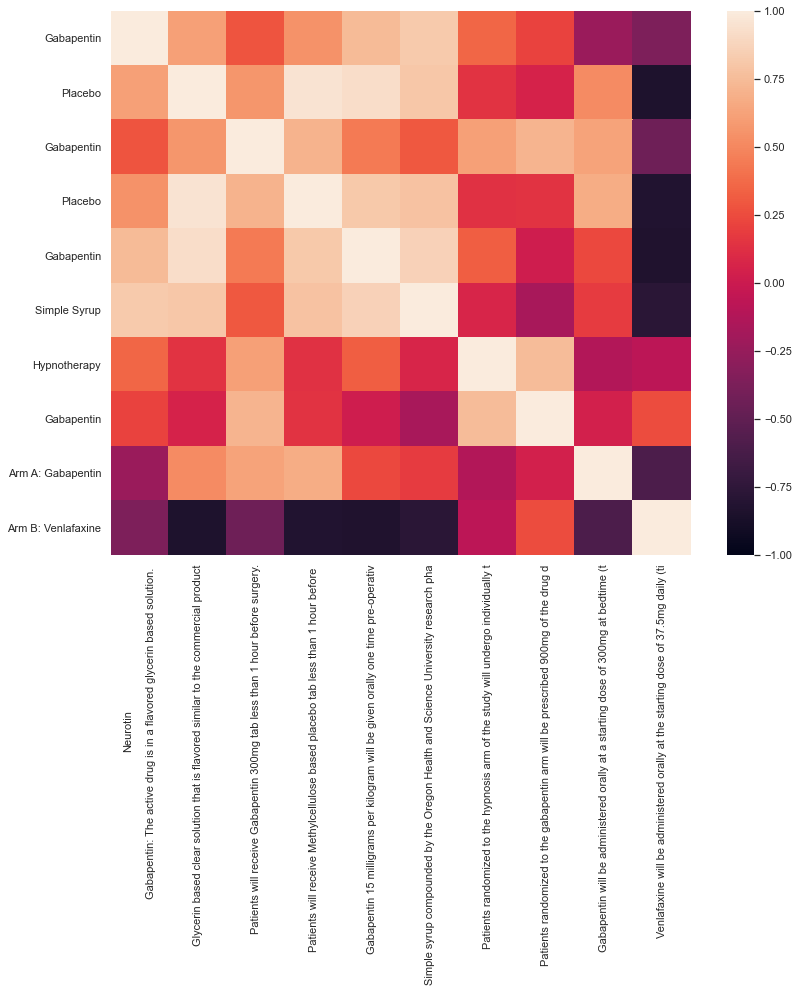

In [105]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(13,10))    
x_heatmap_labels = [x[:80] for x in test_group['description'].to_list()]
y_heatmap_labels = test_group['title'].to_list()
sim_matrix = cosine_similarity(np.array(test_group['embedding'].to_list()))
ax = sns.heatmap(sim_matrix, xticklabels=x_heatmap_labels, yticklabels=y_heatmap_labels, vmax=1, vmin=-1, ax=ax)


In [107]:
test_group

,study_id,group_id,measure,title,description,cluster_label,embedding
0,NCT01675960,OG000,Symptom Relief for Chronic Irritability in Neu...,Gabapentin,Neurotin\n\nGabapentin: The active drug is in ...,0.0,"[0.15165701257498654, -0.03517913496746061, 0...."
1,NCT01675960,OG001,Symptom Relief for Chronic Irritability in Neu...,Placebo,Glycerin based clear solution that is flavored...,0.0,"[0.09034981758212202, 0.35894968202651034, 0.6..."
4,NCT02359110,OG000,NRS (Numerical Rating Scale),Gabapentin,Patients will receive Gabapentin 300mg tab les...,2.0,"[-0.1538664033571504, -0.13702222819153675, 0...."
5,NCT02359110,OG001,NRS (Numerical Rating Scale),Placebo,Patients will receive Methylcellulose based pl...,0.0,"[0.04204807542886435, 0.06834999859725954, 0.5..."
10,NCT01977937,OG000,Difference in Pain Control When Adding Gabapen...,Gabapentin,Gabapentin 15 milligrams per kilogram will be ...,0.0,"[0.388021651367668, 0.2551372529568372, 0.7529..."
11,NCT01977937,OG001,Difference in Pain Control When Adding Gabapen...,Simple Syrup,Simple syrup compounded by the Oregon Health a...,0.0,"[0.6627402860816123, -0.04763860809424969, 0.2..."
64,NCT00711529,OG000,Number of Daily Hot Flashes,Hypnotherapy,Patients randomized to the hypnosis arm of the...,2.0,"[0.01404424720892683, -0.2661741481758595, 1.2..."
65,NCT00711529,OG001,Number of Daily Hot Flashes,Gabapentin,Patients randomized to the gabapentin arm will...,2.0,"[-0.9695942893539506, -0.430706087672978, 0.99..."
82,NCT01533753,OG000,Changes in Quality of Life,Arm A: Gabapentin,Gabapentin will be administered orally at a st...,0.0,"[-0.16633037615083257, -0.004483467975681776, ..."
83,NCT01533753,OG001,Changes in Quality of Life,Arm B: Venlafaxine,Venlafaxine will be administered orally at the...,2.0,"[-0.37852145776993895, -0.11653978914207164, -..."
